# Tweet Sentiment Analysis

[Data Source](https://data.world/crowdflower/brands-and-product-emotions)

## Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# set a random seed for reproducibility
seed = 3490

## Load Data

In [2]:
encodings = ["utf-8-sig", "cp1252", "iso-8859-1", "latin1"]
for encoding in encodings:
    try:
        data = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding=encoding)
    except:
        continue
print(encoding)
data.head()

latin1


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


## Explore Data

In [3]:
print(f'How much data do we have?\n{data.shape[0]} records.')
print('\n')
print(f'Example of a tweet in the dataset:\n"{data.tweet_text[0]}"')
print('\n')
print(f'Which products are the tweets concerning?\n{list(data.emotion_in_tweet_is_directed_at.value_counts().index)}')
print('\n')
class_distribution = data.is_there_an_emotion_directed_at_a_brand_or_product.value_counts(normalize=True)
print(f'Is this an imbalanced classification problem?\n{class_distribution}')

How much data do we have?
9093 records.


Example of a tweet in the dataset:
".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW."


Which products are the tweets concerning?
['iPad', 'Apple', 'iPad or iPhone App', 'Google', 'iPhone', 'Other Google product or service', 'Android App', 'Android', 'Other Apple product or service']


Is this an imbalanced classification problem?
No emotion toward brand or product    0.592654
Positive emotion                      0.327505
Negative emotion                      0.062686
I can't tell                          0.017156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: float64


This is definitely an imbalanced classification problem (in terms of sentiment.)

How much is each brand represented in the dataset?

In [4]:
apple_categories = ['iPad', 'Apple', 'iPad or iPhone App', 'iPhone',
                    'Other Apple product or service']

android_categories = ['Android App', 'Android']

google_categories = ['Google', 'Other Google product or service']

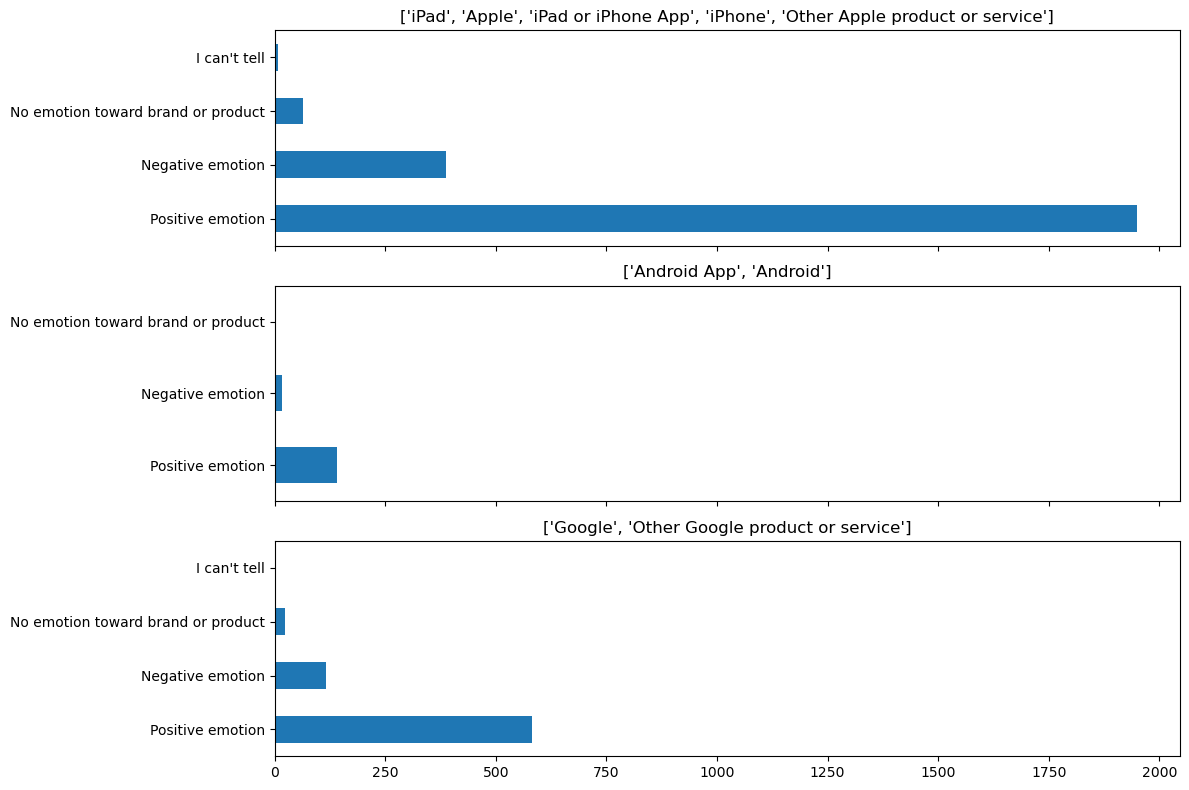

In [19]:
brands = [apple_categories, android_categories, google_categories]

fig, ax = plt.subplots(nrows=3, figsize=(12, 8), sharex=True)

for i, brand in enumerate(brands):
    plt.sca(ax[i])
    data.loc[data.emotion_in_tweet_is_directed_at.isin(brand),
         'is_there_an_emotion_directed_at_a_brand_or_product'].value_counts().plot(
    kind='barh')
    ax[i].set_title(f'{brand}')
    
fig.tight_layout();

## Prepare Data for Modeling

**Handle Missing Data**

Check for missing data.

In [12]:
data.isna().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

For now, we will ignore towards which product the sentiment in the tweet is directed, which allows us to ignore the missing data in the "emotion_in_tweet_is_directed_at" column.

View the record which is missing "tweet_text" data.

In [15]:
data.loc[data.tweet_text == None]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product


We can safely drop this record.

In [3]:
clean_data = data.dropna(subset=['tweet_text'])

**Drop Data for Which Sentiment Category is "I can't tell"**

In [4]:
clean_data = clean_data.loc[clean_data.is_there_an_emotion_directed_at_a_brand_or_product != "I can't tell"]

**Drop Column Specifying At Which Product the Sentiment is Directed**

In [5]:
clean_data = clean_data.drop(columns='emotion_in_tweet_is_directed_at')

**Rename Sentiment Column**

In [6]:
clean_data = clean_data.rename({'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'}, axis=1)

**Inspect First Few Rows of Cleaned Data:**

In [7]:
clean_data.head()

,tweet_text,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion


In [8]:
clean_data.shape

(8936, 2)

## Load Pre-trained GloVe Vectors

Load pre-trained word vectors (to give more context to our 9000 or so tweets.)

In [10]:
with open('data/glove.twitter.27B.50d.txt') as f:
    lines = f.readlines()

In [11]:
glove = dict()

for line in lines:
    items = line.split()
    word = items[0]
    vector = items[1:]
    glove[word] = [float(component) for component in vector]

Save to file, so we don't have to run the above code every time we restart the kernel.

In [13]:
import json
with open("data/glove.txt", "w") as filepath:
    json.dump(glove, filepath) 

**Load preprocessed glove dictionary here:**

In [9]:
import json
with open("data/glove.txt", "r") as file:
    glove = json.load(file)

In [10]:
len(glove.keys())

1193514

We have 1,193,514 words and characters which have been vectorized for us (in the context of Twitter.)

## Train Test Split

The next step is to split our data into training and testing sets, and then preprocess the tweet text for our classifier using our glove vectors.

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(clean_data['tweet_text'],
                                                    clean_data['sentiment'],
                                                    test_size=0.2,
                                                    random_state=seed)

X_train.head(2)

8841    Next #SXSW we're heading to is about designing...
1099    Talked to some great developers at the Android...
Name: tweet_text, dtype: object

## Vectorize Tweets for Modeling

Define a function to go through the text of each tweet and get the (GloVe) vector representation for each word, then mind the mean word vector for the entire tweet.

In [12]:
import string

def get_mean_word_vector(tweet):
    tokens = tweet.split()
    tweet_vectors = []
    for token in tokens:
        try:
            tweet_vectors.append(glove[token.lower().strip(string.punctuation)])
        except:
#             print(token)     we're losing quite a few tokens, but will ignore for now
            continue
    return np.mean(np.array(tweet_vectors), axis=0)

Note that this function does not pad each tweet. I am curious to see the effect of padding versus not padding on the classifier.

In [13]:
X_train_preprocessed = X_train.apply(get_mean_word_vector)

In [14]:
X_test_preprocessed = X_test.apply(get_mean_word_vector)

The series above are not in the correct format for a scikit learn classifier. To convert to a matrix of features, use the below loop:

In [15]:
preprocessed_values = dict()

for i in range(50):
    label = f'feature_{i}'
    values = [vector[i] for vector in X_train_preprocessed.values]
    preprocessed_values[label] = values

final_X_train = pd.DataFrame(preprocessed_values, index=X_train.index)

In [16]:
preprocessed_values = dict()

for i in range(50):
    label = f'feature_{i}'
    values = [vector[i] for vector in X_test_preprocessed.values]
    preprocessed_values[label] = values

final_X_test = pd.DataFrame(preprocessed_values, index=X_test.index)

## Label Encode Target

Label encode the target.

In [15]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y_train_preprocessed = le.fit_transform(y_train)
y_test_preprocessed = le.transform(y_test)

print(le.classes_)

['Negative emotion' 'No emotion toward brand or product'
 'Positive emotion']


## Store Modeling Results

To keep up with the performance of different models, build a dictionary for scores.

In [18]:
model_eval = {'name': [], 'model': [], 'accuracy': []}

from sklearn.base import clone # to store models

## Build Baseline Classifier

Options for classifier:

- logistic regression
- decision tree
- k nearest neighbors
- random forest
- boosted random forest

Our baseline classifier will be a logistic regression.

In [19]:
from sklearn.linear_model import LogisticRegression

For logistic regression, the data needs to be scaled.

In [20]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

scaled_X_train = ss.fit_transform(final_X_train)
scaled_X_test = ss.transform(final_X_test)

Perform cross validation on the scaled training data.

In [21]:
from sklearn.model_selection import cross_val_score

In [22]:
baseline = LogisticRegression(random_state=seed)

cross_val_score(baseline, scaled_X_train, y_train_preprocessed)

array([0.64615385, 0.63706294, 0.63916084, 0.6550035 , 0.64660602])

In [23]:
from sklearn.metrics import make_scorer

def neg_recall_score(y_true, y_preds):
    tn = 0
    fp = 0
    for true_label, predicted_label in zip(y_true, y_preds):
        if true_label == 0:
            if predicted_label == true_label:
                tn += 1
            else:
                fp += 1
    return tn / (tn + fp)

negative_recall_score = make_scorer(neg_recall_score)

cross_val_score(baseline, scaled_X_train, y_train_preprocessed, scoring=negative_recall_score)

array([0.04597701, 0.17241379, 0.08045977, 0.05813953, 0.12643678])

Store the results.

In [24]:
model_eval['name'].append('baseline')
model_eval['model'].append(clone(baseline))
model_eval['accuracy'].append(np.mean(cross_val_score(baseline, scaled_X_train, y_train_preprocessed)))
pd.DataFrame(model_eval)

,name,model,accuracy
0,baseline,LogisticRegression(random_state=3490),0.644797


In [25]:
neg_recall_eval = {'name': [], 'model': [], 'recall_of_negative_tweets': []}

In [26]:
neg_recall_eval['name'].append('baseline')
neg_recall_eval['model'].append(clone(baseline))
neg_recall_eval['recall_of_negative_tweets'].append(
np.mean(cross_val_score(baseline, scaled_X_train, y_train_preprocessed, scoring=negative_recall_score)))
pd.DataFrame(neg_recall_eval)

,name,model,recall_of_negative_tweets
0,baseline,LogisticRegression(random_state=3490),0.096685


Explore the results a little more. Examine where the model is making correct predictions and where it is making incorrect predictions.

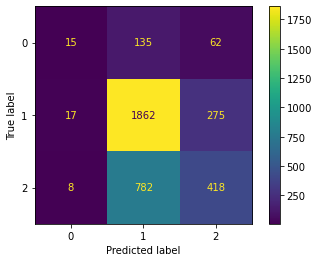

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold

kfolds = KFold(n_splits=2, shuffle=True, random_state=seed)

for train, test in kfolds.split(scaled_X_train, y_train_preprocessed):
    train_split = train
    test_split = test
    break
    
baseline.fit(scaled_X_train[train_split], y_train_preprocessed[train_split])
ConfusionMatrixDisplay(confusion_matrix(y_train_preprocessed[test_split],
                                        baseline.predict(scaled_X_train[test_split])
                                       )).plot();

In [28]:
print(f'The model is predicting the majority class "{le.classes_[1]}" quite well.')
print(f'The model is classifying a large proportion of the other two classes as the majority class.')

The model is predicting the majority class "No emotion toward brand or product" quite well.
The model is classifying a large proportion of the other two classes as the majority class.


Here is the percentage of each true class which is correctly labeled. The model's recall for each class is on the diagonal.

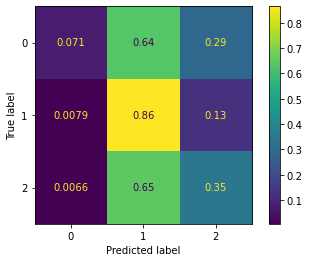

In [29]:
ConfusionMatrixDisplay(confusion_matrix(y_train_preprocessed[test_split],
                                        baseline.predict(scaled_X_train[test_split]),
                                        normalize='true'
                                       )).plot();

Here is the percentage of the model's predictions for each class which are correct. The model's precision for each class is on the diagonal.

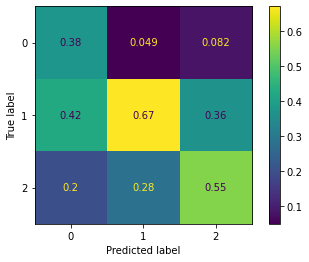

In [30]:
ConfusionMatrixDisplay(confusion_matrix(y_train_preprocessed[test_split],
                                        baseline.predict(scaled_X_train[test_split]),
                                        normalize='pred'
                                       )).plot();

In [31]:
le.classes_[0]

'Negative emotion'

In [32]:
cf = confusion_matrix(y_train_preprocessed[test_split], baseline.predict(scaled_X_train[test_split]))

print('Recall of Negative Emotion Tweets:')
print(cf[0][0] / np.sum([cf[0][i] for i in range(3)]))

Recall of Negative Emotion Tweets:
0.07075471698113207


## Evaluation Metrics

Looking at the accuracy for each class is a reasonable measure of the model's performance.

It is also important to look at the **recall for negative tweets** in particular because we want to respond quickly to negative feedback to improve customer satisfaction and brand perception.

Right now, our model has a recall for negative tweets specifically of only 7%.

## Increase Recall of Negative Tweets

One strategy for increasing the model's recall of negative tweets is to change the threshold for predicting that a tweet is negative.

Currently, our model selects the category with the highest probability.

For example, if the predicted probabilities for negative, neutral and positive are $.33$, $.36$ and $.31$, then the model will predict that the tweet is neutral. But if the model has even a 30% confidence that the tweet is negative, we may want to classify that tweet as negative.

We can set some custom thresholds as follows:

- If the model is 30% confident (or more) that a tweet is negative, and less than 50% confident that the tweet is neutral or positive, then classify the tweet as negative.

- Otherwise, classify the tweet according to highest confidence level.

In [33]:
import random

thresholded_preds = []

for probs in baseline.predict_proba(scaled_X_train[test_split]):
    if probs[0] >= 0.3:
        if (probs[1] <= 0.5) and (probs[2] <= 0.5):
            thresholded_preds.append(0)
        elif probs[1] > 0.5:
            thresholded_preds.append(1)
        else:
            thresholded_preds.append(2)
    else:
        if probs[1] > probs[2]:
            thresholded_preds.append(1)
        elif probs[1] < probs[2]:
            thresholded_preds.append(2)
        else:
            thresholded_preds.append(random.randint(1,2))

Check recall of thresholded predictions.

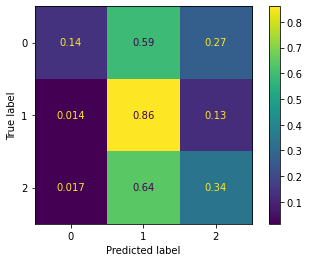

In [34]:
ConfusionMatrixDisplay(confusion_matrix(y_train_preprocessed[test_split],
                                        thresholded_preds,
                                        normalize='true'
                                       )).plot();

Applying some custom thresholding increased the recall of negative tweets from 7% to 14%.

Make the above thresholding code into a function to apply repeatedly in search of the best thresholding schema.

In [35]:
import random

def custom_threshold_predict(model, X, neg_threshold, pos_threshold, neut_threshold):
    
    thresholded_preds = []

    for probs in model.predict_proba(X):
        # negative tweet confidence above threshold
        if probs[0] >= neg_threshold:
            # positive and neutral confidence below thresholds
            if (probs[1] <= neut_threshold) and (probs[2] <= pos_threshold):
                thresholded_preds.append(0)
            # positive and neutral confidence both above thresholds
            elif (probs[1] > neut_threshold) and (probs[2] > pos_threshold):
                # select class with highest probability, or choose randomly if equal
                if probs[1] > probs[2]:
                    thresholded_preds.append(1)
                elif probs[1] < probs[2]:
                    thresholded_preds.append(2)
                else:
                    thresholded_preds.append(random.randint(1,2))
            # positive or netural confidence is above, the other is below, their thresholds 
            elif (probs[1] > neut_threshold) and (probs[2] < pos_threshold):
                thresholded_preds.append(1)
            elif (probs[1] < neut_threshold) and (probs[2] > pos_threshold):
                thresholded_preds.append(2)
            # if all three classes are outside of their thresholds, pick class with highest probability
            else:
                thresholded_preds.append(np.argmax(probs))
        # if negative tweet confidence is NOT above threshold, pick highest probability
        else:
            thresholded_preds.append(np.argmax(probs))
            
    return thresholded_preds

Store results.

In [36]:
from sklearn.metrics import accuracy_score

model_eval['name'].append('thresholded_baseline')
model_eval['model'].append(clone(baseline))
model_eval['accuracy'].append(accuracy_score(y_train_preprocessed[test_split], thresholded_preds))
pd.DataFrame(model_eval)

,name,model,accuracy
0,baseline,LogisticRegression(random_state=3490),0.644797
1,thresholded_baseline,LogisticRegression(random_state=3490),0.641578


In [37]:
neg_recall_eval['name'].append('thresholded_baseline')
neg_recall_eval['model'].append(clone(baseline))
neg_recall_eval['recall_of_negative_tweets'].append(
neg_recall_score(y_train_preprocessed[test_split], thresholded_preds))
pd.DataFrame(neg_recall_eval)

,name,model,recall_of_negative_tweets
0,baseline,LogisticRegression(random_state=3490),0.096685
1,thresholded_baseline,LogisticRegression(random_state=3490),0.136792


Now, let's tune the classification algorithm itself, then threshold the best classifier found.

## Test Padding Mean Word Vector for Different Length Tweets

In [38]:
X_train.map(lambda x: len(x.split())).describe()

count    7148.000000
mean       17.758254
std         4.954223
min         2.000000
25%        14.000000
50%        18.000000
75%        21.000000
max        32.000000
Name: tweet_text, dtype: float64

Based on the above descriptive statistics for the length (in words) of each tweet, 21 would be a good "length" for the mean tweet vector.

\*Note: the mean tweet vector has a dimensionality of 50, but I am going to try considering a list of word vectors of length 21, regardless of whether a tweet has fewer or greater than 21 words in it.

In [39]:
test_array = [[1, 2, 5], [3, 4, 7]]
test_array.append([0]*3)
np.array(test_array)

array([[1, 2, 5],
       [3, 4, 7],
       [0, 0, 0]])

In [40]:
import string

def get_mean_word_vector2(tweet):
    tokens = tweet.split()
    tweet_vectors = []
    for token in tokens:
        try:
            tweet_vectors.append(glove[token.lower().strip(string.punctuation)])
        except:
#             print(token)     we're losing quite a few tokens, but will ignore for now
            continue
    # pad with 0 vectors if less than 21 words in length
    while len(tweet_vectors) < 21:
        tweet_vectors.append([0]*50)
    # save first 21 word vectors as an array
    padded_tweet_vector = np.array(tweet_vectors[:21])
    # return the mean of these 21 word vectors
    return np.mean(padded_tweet_vector, axis=0)

In [41]:
X_train_preprocessed2 = X_train.apply(get_mean_word_vector2)

X_test_preprocessed2 = X_test.apply(get_mean_word_vector2)

In [42]:
preprocessed_values = dict()

for i in range(50):
    label = f'feature_{i}'
    values = [vector[i] for vector in X_train_preprocessed.values]
    preprocessed_values[label] = values

final_X_train2 = pd.DataFrame(preprocessed_values, index=X_train.index)

preprocessed_values = dict()

for i in range(50):
    label = f'feature_{i}'
    values = [vector[i] for vector in X_test_preprocessed.values]
    preprocessed_values[label] = values

final_X_test2 = pd.DataFrame(preprocessed_values, index=X_test.index)

In [43]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

scaled_X_train2 = ss.fit_transform(final_X_train2)
scaled_X_test2 = ss.transform(final_X_test2)

In [44]:
cross_val_score(baseline, scaled_X_train2, y_train_preprocessed)

array([0.64615385, 0.63706294, 0.63916084, 0.6550035 , 0.64660602])

In [45]:
model_eval['name'].append('baseline_w_padded_mean_word_vector')
model_eval['model'].append(clone(baseline))
model_eval['accuracy'].append(np.mean(cross_val_score(baseline, scaled_X_train2, y_train_preprocessed)))
pd.DataFrame(model_eval)

,name,model,accuracy
0,baseline,LogisticRegression(random_state=3490),0.644797
1,thresholded_baseline,LogisticRegression(random_state=3490),0.641578
2,baseline_w_padded_mean_word_vector,LogisticRegression(random_state=3490),0.644797


In [46]:
neg_recall_eval['name'].append('baseline_w_padded_mean_word_vector')
neg_recall_eval['model'].append(clone(baseline))
neg_recall_eval['recall_of_negative_tweets'].append(
np.mean(cross_val_score(baseline, scaled_X_train2, y_train_preprocessed, scoring=negative_recall_score)))
pd.DataFrame(neg_recall_eval)

,name,model,recall_of_negative_tweets
0,baseline,LogisticRegression(random_state=3490),0.096685
1,thresholded_baseline,LogisticRegression(random_state=3490),0.136792
2,baseline_w_padded_mean_word_vector,LogisticRegression(random_state=3490),0.096685


There is practically no difference, so I will continue without padding.

## Tuning Logistic Regression

In [47]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'C': [0.001, 0.1, 1, 1000],
     'class_weight': [None, 'balanced'],
     'random_state': [seed],
     'max_iter': [1000]},
    {'penalty': ['elasticnet'],
     'solver': ['saga'],
     'l1_ratio': [0.25, 0.5, 0.75],
     'C': [0.001, 0.1, 1, 1000],
     'max_iter': [1000]},
    {'penalty': ['l1'],
     'solver': ['saga'],
     'C': [0.001, 0.1, 1, 1000],
     'random_state': [seed],
     'max_iter': [1000]}
]

logreg = LogisticRegression()

grid_search = GridSearchCV(logreg, param_grid, scoring='accuracy')

grid_search.fit(scaled_X_train, y_train_preprocessed)

print(grid_search.best_score_)

KeyboardInterrupt: 

In [ ]:
# store accuracy for logreg tuned for accuracy

model_eval['name'].append('tuned_logreg')
model_eval['model'].append(clone(grid_search.best_estimator_))
model_eval['accuracy'].append(grid_search.best_score_)
pd.DataFrame(model_eval)

In [ ]:
# store recall for logreg tuned for accuracy

neg_recall_eval['name'].append('tuned_logreg')
neg_recall_eval['model'].append(clone(grid_search.best_estimator_))
neg_recall_eval['recall_of_negative_tweets'].append(
np.mean(cross_val_score(grid_search.best_estimator_, scaled_X_train, y_train_preprocessed, scoring=negative_recall_score)))
pd.DataFrame(neg_recall_eval)

In [ ]:
# optimize for negative recall instead

grid_search = GridSearchCV(logreg, param_grid, scoring=negative_recall_score)

grid_search.fit(scaled_X_train, y_train_preprocessed)

print(grid_search.best_score_)

In [ ]:
grid_search.best_estimator_

In [ ]:
# store results
model_eval['name'].append('logreg_tuned_for_neg_recall')
model_eval['model'].append(clone(grid_search.best_estimator_))
model_eval['accuracy'].append(
np.mean(cross_val_score(grid_search.best_estimator_, scaled_X_train, y_train_preprocessed)))
pd.DataFrame(model_eval)

In [ ]:
# store neg recall results

neg_recall_eval['name'].append('logreg_tuned_for_neg_recall')
neg_recall_eval['model'].append(clone(grid_search.best_estimator_))
neg_recall_eval['recall_of_negative_tweets'].append(grid_search.best_score_)
pd.DataFrame(neg_recall_eval)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=seed)

np.mean(cross_val_score(rf, scaled_X_train, y_train_preprocessed))

In [ ]:
model_eval['name'].append('baseline_random_forest')
model_eval['model'].append(clone(rf))
model_eval['accuracy'].append(np.mean(cross_val_score(rf, scaled_X_train, y_train_preprocessed)))
pd.DataFrame(model_eval)

In [ ]:
neg_recall_eval['name'].append('baseline_random_forest')
neg_recall_eval['model'].append(clone(rf))
neg_recall_eval['recall_of_negative_tweets'].append(
np.mean(cross_val_score(rf, scaled_X_train, y_train_preprocessed, scoring=negative_recall_score)))
pd.DataFrame(neg_recall_eval)

**Make a function to record model results:**

In [ ]:
def log_model_results(name, model, x_data=scaled_X_train, y_data=y_train_preprocessed):
    '''Pass in a name and a model; store model's name, a clone of model & accuracy.'''
    global model_eval
    global neg_recall_eval

    model_eval['name'].append(name)
    model_eval['model'].append(clone(model))
    model_score = np.mean(cross_val_score(model, x_data, y_data))
    model_eval['accuracy'].append(model_score)
    
    neg_recall_eval['name'].append(name)
    neg_recall_eval['model'].append(clone(model))
    nr_score = np.mean(cross_val_score(model, x_data, y_data, scoring=negative_recall_score))
    neg_recall_eval['recall_of_negative_tweets'].append(nr_score)
    
    return pd.concat([pd.DataFrame(model_eval), pd.DataFrame(neg_recall_eval)], axis=1)

In [ ]:
pd.DataFrame(neg_recall_eval)

## Build Custom word2Vec Embeddings 2

In [ ]:
import gensim

In [ ]:
corpus = []
for tweet in X_train.values:
    corpus.append(gensim.utils.simple_preprocess(tweet))

In [ ]:
custom_embeddings = gensim.models.Word2Vec(corpus,
                                           size=50,
                                           window=5,
                                           iter=10)

In [ ]:
import string

def get_custom_mean_word_vector(tweet):
    tokens = tweet.split()
    tweet_vectors = []
    for token in tokens:
        try:
            tweet_vectors.append(custom_embeddings.wv[token.lower().strip(string.punctuation)])
        except:
            continue
    return np.mean(np.array(tweet_vectors), axis=0)

In [ ]:
X_train_preprocessed3 = X_train.apply(get_custom_mean_word_vector)

In [ ]:
preprocessed_values = dict()

for i in range(50):
    label = f'feature_{i}'
    values = [vector[i] for vector in X_train_preprocessed3.values]
    preprocessed_values[label] = values

final_X_train3 = pd.DataFrame(preprocessed_values, index=X_train.index)

In [ ]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

scaled_X_train3 = ss.fit_transform(final_X_train3)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

baseline = LogisticRegression(random_state=seed, max_iter=10000)

np.mean(cross_val_score(baseline, scaled_X_train3, y_train_preprocessed))

In [ ]:
log_model_results('custom_embeddings', baseline, scaled_X_train3, y_train_preprocessed)

## Tuning Random Forest

In [ ]:
balanced_rf = RandomForestClassifier(random_state=seed, class_weight='balanced')

In [ ]:
log_model_results('balanced_rf', balanced_rf)

In [ ]:
balanced_rf.fit(scaled_X_train, y_train_preprocessed)

In [ ]:
estimator_depths = [estimator.get_depth() for estimator in balanced_rf.estimators_]
print(f'Mean depth: {np.mean(estimator_depths)}')
print(f'Standard deviation: {np.std(estimator_depths)}')

In [ ]:
param_grid = [
    {'random_state': [seed],
     'max_depth': [5, 10, 20, 30],
     'class_weight': [None, 'balanced']}
]

grid_search = GridSearchCV(rf, param_grid, scoring=negative_recall_score)

grid_search.fit(scaled_X_train, y_train_preprocessed)

In [ ]:
grid_search.best_score_

In [ ]:
log_model_results('tuned_rf', grid_search.best_estimator_)

## Binary Classifier

In [ ]:
clean_data.head()

In [ ]:
clean_data.sentiment.value_counts(normalize=True)

In [ ]:
binary_data = clean_data.loc[clean_data.sentiment != 'No emotion toward brand or product']

In [ ]:
binary_data.sentiment.value_counts(normalize=True)

In [ ]:
binary_model_eval = {'name': [], 'model': [], 'accuracy': []}

from sklearn.base import clone # to store models

In [ ]:
def log_binary_model_results(name, model, x_data, y_data):
    '''Pass in a name and a model; store model's name, a clone of model & accuracy.'''
    global binary_model_eval

    binary_model_eval['name'].append(name)
    binary_model_eval['model'].append(clone(model))
    model_score = np.mean(cross_val_score(model, x_data, y_data))
    binary_model_eval['accuracy'].append(model_score)
    
    return pd.DataFrame(binary_model_eval)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(binary_data['tweet_text'],
                                                    binary_data['sentiment'],
                                                    test_size=0.2,
                                                    random_state=seed)

In [ ]:
y_train.value_counts(normalize=True)

In [ ]:
y_test.value_counts(normalize=True)

### Preprocessing with GloVe

In [ ]:
# GloVe word2vec vectorization
preprocessed_train_values = dict()
preprocessed_test_values = dict()

for i in range(50):
    label = f'feature_{i}'
    # get i^th component of each mean tweet vector
    train_values = [vector[i] for vector in X_train.apply(get_mean_word_vector)]
    test_values = [vector[i] for vector in X_test.apply(get_mean_word_vector)]
    # store
    preprocessed_train_values[label] = train_values
    preprocessed_test_values[label] = test_values

final_X_train = pd.DataFrame(preprocessed_train_values, index=X_train.index)
final_X_test = pd.DataFrame(preprocessed_test_values, index=X_test.index)

In [ ]:
# scale
scaled_X_train = ss.fit_transform(final_X_train)
scaled_X_test = ss.transform(final_X_test)

In [ ]:
# label encode target
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y_train_preprocessed = le.fit_transform(y_train)
y_test_preprocessed = le.transform(y_test)

print(le.classes_)

In [ ]:
# score baseline
baseline = LogisticRegression(random_state=seed)

np.mean(cross_val_score(baseline, scaled_X_train, y_train_preprocessed))

In [ ]:
log_binary_model_results('GloVe', baseline, scaled_X_train, y_train_preprocessed)

In [ ]:
# examine positive / negative breakdown
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold

kfolds = KFold(n_splits=2, shuffle=True, random_state=seed)

for train, test in kfolds.split(scaled_X_train, y_train_preprocessed):
    train_split = train
    test_split = test
    break
    
baseline.fit(scaled_X_train[train_split], y_train_preprocessed[train_split])
ConfusionMatrixDisplay(confusion_matrix(y_train_preprocessed[test_split],
                                        baseline.predict(scaled_X_train[test_split])
                                       )).plot();

In [ ]:
# Check recall of negative tweets
ConfusionMatrixDisplay(confusion_matrix(y_train_preprocessed[test_split],
                                        baseline.predict(scaled_X_train[test_split]),
                                        normalize='true'
                                       )).plot();

18% of negative tweets are being captured.

In [ ]:
# undersample
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=seed)

X_train_undersampled, y_train_undersampled = rus.fit_resample(scaled_X_train,
                                                              y_train_preprocessed)

In [ ]:
# refit
baseline.fit(X_train_undersampled, y_train_undersampled)

# Check recall of negative tweets
ConfusionMatrixDisplay(confusion_matrix(y_test_preprocessed,
                                        baseline.predict(scaled_X_test),
                                        normalize='true'
                                       )).plot();

In [ ]:
np.mean(cross_val_score(baseline, X_train_undersampled, y_train_undersampled))

In [ ]:
log_binary_model_results('random_under_sampling', baseline, X_train_undersampled,
                         y_train_undersampled)

Undersampling drastically decreases the overall accuracy of the model, but drastically increases the recall of negative tweets.

In [ ]:
recall_of_neg_tweets = []
overall_accuracy = []

for ratio in np.linspace(0.5, 1, 6):
    rus = RandomUnderSampler(random_state=seed, sampling_strategy=ratio)
    
    X_train_undersampled, y_train_undersampled = rus.fit_resample(scaled_X_train,
                                                                  y_train_preprocessed)
    
    baseline.fit(X_train_undersampled, y_train_undersampled)

    overall_accuracy.append(accuracy_score(y_test_preprocessed,
                                           baseline.predict(scaled_X_test)))
    neg_recall = confusion_matrix(y_test_preprocessed, baseline.predict(scaled_X_test),
                                  normalize='true')[0][0]
    recall_of_neg_tweets.append(neg_recall)

In [ ]:
fig, ax = plt.subplots()

plt.plot(np.linspace(0.5, 1, 6), overall_accuracy, label='accuracy')
plt.plot(np.linspace(0.5, 1, 6), recall_of_neg_tweets, label='negative recall')

ax.legend();

In [ ]:
# Check precision of positive/negative tweets

rus = RandomUnderSampler(random_state=seed)

X_train_undersampled, y_train_undersampled = rus.fit_resample(scaled_X_train,
                                                              y_train_preprocessed)

baseline.fit(X_train_undersampled, y_train_undersampled)

ConfusionMatrixDisplay(confusion_matrix(y_test_preprocessed,
                                        baseline.predict(scaled_X_test),
                                        normalize='pred'
                                       )).plot();

With undersampling, our model has 36% precision in negative tweets, and 93% precision in positive tweets. (It is only right 36% of the time when predicting that a tweet is negative!)

### Preprocessing as a Bag of Words

In [ ]:
from nltk.tokenize import word_tokenize
import string

def custom_tokenize(tweet):
    list_of_words = tweet.split()
    clean_list = [word.strip(string.punctuation).lower() for word in list_of_words]
    clean_tweet = ' '.join(clean_list)
    return word_tokenize(clean_tweet)

In [ ]:
test_tweet = "@samantha here is a test tweet!! to make sure This works."

In [ ]:
custom_tokenize(test_tweet)

In [ ]:
X_train.apply(custom_tokenize)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,2), max_df=0.95, min_df=0.05)

tfidf_X_train = pd.DataFrame(
    tfidf.fit_transform(X_train.apply(lambda x: ' '.join(custom_tokenize(x)))).todense(),
    columns=list(tfidf.vocabulary_.keys()),
    index=X_train.index)

In [ ]:
tfidf_X_test = pd.DataFrame(
    tfidf.transform(X_test.apply(lambda x: ' '.join(custom_tokenize(x)))).todense(),
    columns=list(tfidf.vocabulary_.keys()),
    index=X_test.index)

In [ ]:
np.mean(
cross_val_score(baseline, tfidf_X_train, y_train_preprocessed)
)

In [ ]:
log_binary_model_results('Tfidf', baseline, tfidf_X_train, y_train_preprocessed)

In [ ]:
tfidf_X_train.head()

In [ ]:
baseline.fit(tfidf_X_train, y_train_preprocessed)

ConfusionMatrixDisplay(confusion_matrix(y_test_preprocessed,
                                        baseline.predict(tfidf_X_test)
                                       )).plot();

In [ ]:

ConfusionMatrixDisplay(confusion_matrix(y_test_preprocessed,
                                        baseline.predict(tfidf_X_test),
                                        normalize='true'
                                       )).plot();

Using a simple bag of words representation with term frequency inverse document frequency vectorization results in the best recall of positive tweets so far, but the worst recall of negative tweets so far.

## Use TextBlob

In [12]:
from textblob import TextBlob

train_sentiments = X_train.apply(lambda x: TextBlob(x).sentiment[0])

ModuleNotFoundError: No module named 'textblob'

In [ ]:
from sklearn.metrics import accuracy_score

tb_preds = []

for sentiment in train_sentiments:
    if sentiment > 0:
        tb_preds.append(1)
    else:
        tb_preds.append(0)
        
accuracy_score(y_train_preprocessed, tb_preds)

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_preprocessed, tb_preds, normalize='true')

With TextBlob's sentiment attribute, we are able to achieve a 62% recall of negative tweets, and an overall accuracy of 61.6%.

## Stacking

Let's try stacking the mean word vectors for each tweet, along with the TextBlob sentiment rating for the tweet, into one long vector which will be passed into the classifier.

### Stack Vectors

In [13]:
# GloVe vectors

import string
def get_mean_word_vector(tweet):
    tokens = tweet.split()
    tweet_vectors = []
    for token in tokens:
        try:
            tweet_vectors.append(glove[token.lower().strip(string.punctuation)])
        except:
            continue
    return np.mean(np.array(tweet_vectors), axis=0)

preprocessed_train_values = dict()
preprocessed_test_values = dict()
for i in range(50):
    label = f'feature_{i}'
    train_values = [vector[i] for vector in X_train.apply(get_mean_word_vector).values]
    test_values = [vector[i] for vector in X_test.apply(get_mean_word_vector).values]
    preprocessed_train_values[label] = train_values
    preprocessed_test_values[label] = test_values

final_X_train = pd.DataFrame(preprocessed_train_values, index=X_train.index)
final_X_test = pd.DataFrame(preprocessed_test_values, index=X_test.index)

In [14]:
final_X_train.head(2)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
8841,0.319201,0.395279,-0.176584,-0.131364,-0.071595,0.083308,0.705606,-0.034821,0.228301,-0.119688,...,-0.714364,0.172167,0.171923,0.094589,0.099394,-0.244238,-0.124904,-0.021861,-0.306482,0.078222
1099,0.313010,0.332674,-0.139310,-0.143318,0.148534,0.099929,0.650696,-0.196787,0.133210,-0.467467,...,-0.750454,0.414936,0.180222,0.217292,0.367504,0.074869,-0.209672,-0.156023,-0.255526,0.273825


In [ ]:
import gensim

corpus = []
for tweet in X_train.values:
    corpus.append(gensim.utils.simple_preprocess(tweet))

custom_embeddings = gensim.models.Word2Vec(corpus,
                                           size=50,
                                           window=5,
                                           iter=10)

def get_custom_mean_word_vector(tweet):
    tokens = tweet.split()
    tweet_vectors = []
    for token in tokens:
        try:
            tweet_vectors.append(custom_embeddings.wv[token.lower().strip(string.punctuation)])
        except:
            continue
    return np.mean(np.array(tweet_vectors), axis=0)

preprocessed_train_values2 = dict()
preprocessed_test_values2 = dict()
for i in range(50):
    label = f'feature_{50+i}'
    train_values = [vector[i] for vector in X_train.apply(get_custom_mean_word_vector).values]
    test_values = [vector[i] for vector in X_test.apply(get_custom_mean_word_vector).values]
    preprocessed_train_values2[label] = train_values
    preprocessed_test_values2[label] = test_values
    
new_X_train = pd.concat(
    [final_X_train, pd.DataFrame(preprocessed_train_values2, index=X_train.index)], axis=1)
new_X_test = pd.concat(
    [final_X_test, pd.DataFrame(preprocessed_test_values2, index=X_test.index)], axis=1)

In [ ]:
new_X_train.head(3)

In [ ]:
stacked_X_train = pd.concat(
    [new_X_train,
     X_train.apply(lambda x: TextBlob(x).sentiment[0]).rename('polarity')], axis=1)

In [ ]:
stacked_X_test = pd.concat(
    [new_X_test,
     X_test.apply(lambda x: TextBlob(x).sentiment[0]).rename('polarity')], axis=1)

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(baseline, stacked_X_train, y_train_preprocessed)

In [ ]:
log_binary_model_results('stacked', baseline, stacked_X_train, y_train_preprocessed)

In [ ]:
baseline.fit(stacked_X_train, y_train_preprocessed)

baseline.score(stacked_X_test, y_test_preprocessed)

The baseline model above is just slightly overfit.

In [ ]:
logreg2 = LogisticRegression(random_state=seed, max_iter=10000, C=0.1)

logreg2.fit(stacked_X_train, y_train_preprocessed)

print(f'Train: {logreg2.score(stacked_X_train, y_train_preprocessed)}')
print(f'Validate: {logreg2.score(stacked_X_test, y_test_preprocessed)}')

In [ ]:
logreg2 = LogisticRegression(random_state=seed, max_iter=10000, C=0.01)

logreg2.fit(stacked_X_train, y_train_preprocessed)

print(f'Train: {logreg2.score(stacked_X_train, y_train_preprocessed)}')
print(f'Validate: {logreg2.score(stacked_X_test, y_test_preprocessed)}')

In [ ]:
logreg2 = LogisticRegression(random_state=seed, max_iter=10000, C=0.001)

logreg2.fit(stacked_X_train, y_train_preprocessed)

print(f'Train: {logreg2.score(stacked_X_train, y_train_preprocessed)}')
print(f'Validate: {logreg2.score(stacked_X_test, y_test_preprocessed)}')

In [ ]:
ConfusionMatrixDisplay(
    confusion_matrix(y_test_preprocessed,
                     logreg2.predict(stacked_X_test))).plot();

## Neural Network

In [16]:
# use GloVe representations of training samples & label encoded target

print(final_X_train.shape)
print(len(y_train_preprocessed))

(7148, 50)
7148


In [38]:
small_X_train, X_val, small_y_train, y_val = train_test_split(final_X_train,
                                                              y_train_preprocessed,
                                                              random_state=seed,
                                                              test_size=0.2)

In [39]:
keras_x_train = np.array([small_X_train.loc[index, :] for index in small_X_train.index])
keras_x_train

array([[ 0.38890994,  0.38823026, -0.23611706, ..., -0.2843165 ,
        -0.07937669,  0.12944787],
       [ 0.16540858,  0.32137779, -0.22078753, ..., -0.02276947,
        -0.23022126, -0.04892733],
       [ 0.129906  ,  0.37524   , -0.529428  , ..., -0.64052   ,
        -0.5977468 ,  0.5321534 ],
       ...,
       [ 0.190514  ,  0.39460748, -0.07391993, ..., -0.12904906,
        -0.15380095,  0.05913938],
       [ 0.12663817,  0.07791975,  0.11411817, ..., -0.26895467,
        -0.0878075 ,  0.22643275],
       [ 0.21509321,  0.408059  , -0.14477979, ..., -0.43829263,
        -0.29817321,  0.24084842]])

In [40]:
keras_x_train.shape

(5718, 50)

In [44]:
keras_x_val = np.array([X_val.loc[index, :] for index in X_val.index])
print(keras_x_val.shape)

(1430, 50)


In [41]:
import keras

keras_y_train = keras.utils.to_categorical(small_y_train, 3)

In [42]:
keras_y_train.shape

(5718, 3)

In [45]:
keras_y_val = keras.utils.to_categorical(y_val, 3)
print(keras_y_val.shape)

(1430, 3)


Test model:

In [47]:
model = Sequential()
# add input layer, and a dense layer with given width
model.add(layers.Input(shape=(50,)))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
    
model.compile(loss='categorical_crossentropy',
              metrics='accuracy')
    
results = model.fit(keras_x_train, keras_y_train,
                    validation_data = [keras_x_val, keras_y_val],
                    batch_size=30, epochs=10)
    
results.history

Epoch 1/10
191/191 [==============================] - 0s 1ms/step - loss: 0.9505 - accuracy: 0.5836 - val_loss: 0.8484 - val_accuracy: 0.6035
Epoch 2/10
191/191 [==============================] - 0s 876us/step - loss: 0.8290 - accuracy: 0.5986 - val_loss: 0.7983 - val_accuracy: 0.6084
Epoch 3/10
191/191 [==============================] - 0s 882us/step - loss: 0.8119 - accuracy: 0.6032 - val_loss: 0.7902 - val_accuracy: 0.6105
Epoch 4/10
191/191 [==============================] - 0s 851us/step - loss: 0.8049 - accuracy: 0.6093 - val_loss: 0.7840 - val_accuracy: 0.6196
Epoch 5/10
191/191 [==============================] - 0s 843us/step - loss: 0.7978 - accuracy: 0.6149 - val_loss: 0.7766 - val_accuracy: 0.6252
Epoch 6/10
191/191 [==============================] - 0s 872us/step - loss: 0.7918 - accuracy: 0.6233 - val_loss: 0.7716 - val_accuracy: 0.6266
Epoch 7/10
191/191 [==============================] - 0s 852us/step - loss: 0.7865 - accuracy: 0.6250 - val_loss: 0.7673 - val_accuracy: 0

{'loss': [0.9504909515380859,
  0.8290156722068787,
  0.8119375705718994,
  0.8049306273460388,
  0.7977656722068787,
  0.7918465733528137,
  0.7864668965339661,
  0.7819296717643738,
  0.7780820727348328,
  0.7740059494972229],
 'accuracy': [0.5835956335067749,
  0.5986359119415283,
  0.6031829118728638,
  0.6093039512634277,
  0.6149002909660339,
  0.6232948303222656,
  0.6250437498092651,
  0.6243441700935364,
  0.6290661096572876,
  0.6302903294563293],
 'val_loss': [0.8484165072441101,
  0.7982558608055115,
  0.7902095913887024,
  0.7840167284011841,
  0.7765704393386841,
  0.7715634107589722,
  0.7673218846321106,
  0.7665272355079651,
  0.76240074634552,
  0.7601288557052612],
 'val_accuracy': [0.6034964919090271,
  0.6083915829658508,
  0.6104894876480103,
  0.6195804476737976,
  0.6251748204231262,
  0.6265734434127808,
  0.6265734434127808,
  0.6314685344696045,
  0.6265734434127808,
  0.6258741021156311]}

In [49]:
from keras import layers, Sequential

hidden_layer_widths = [5, 10, 20, 50, 100, 200]

train_loss = []
val_loss = []
train_acc = []
val_acc = []

for n in hidden_layer_widths:
    model = Sequential()
    # add input layer, and a dense layer with given width
    model.add(layers.Input(shape=(50,)))
    model.add(layers.Dense(n, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  metrics='accuracy')
    
    results = model.fit(keras_x_train,
                        keras_y_train,
                        validation_data=[keras_x_val, keras_y_val],
                        batch_size=30,
                        epochs=30)
    
    history = results.history
    
    train_loss.append(history['loss'])
    val_loss.append(history['val_loss'])
    train_acc.append(history['accuracy'])
    val_acc.append(history['val_accuracy'])
    
# eventually, plot loss & accuracy versus hidden layer width
# plot training with lower opacity, validation full strength
# one color for loss (red), one color for accuracy (blue)
# one plot for 10 epochs, one plot for 50 epochs

Epoch 1/30
191/191 [==============================] - 0s 1ms/step - loss: 0.9118 - accuracy: 0.5845 - val_loss: 0.8162 - val_accuracy: 0.6042
Epoch 2/30
191/191 [==============================] - 0s 874us/step - loss: 0.8166 - accuracy: 0.6011 - val_loss: 0.7910 - val_accuracy: 0.6168
Epoch 3/30
191/191 [==============================] - 0s 852us/step - loss: 0.8009 - accuracy: 0.6088 - val_loss: 0.7757 - val_accuracy: 0.6119
Epoch 4/30
191/191 [==============================] - 0s 865us/step - loss: 0.7897 - accuracy: 0.6168 - val_loss: 0.7665 - val_accuracy: 0.6259
Epoch 5/30
191/191 [==============================] - 0s 854us/step - loss: 0.7820 - accuracy: 0.6233 - val_loss: 0.7628 - val_accuracy: 0.6315
Epoch 6/30
191/191 [==============================] - 0s 944us/step - loss: 0.7760 - accuracy: 0.6271 - val_loss: 0.7558 - val_accuracy: 0.6399
Epoch 7/30
191/191 [==============================] - 0s 898us/step - loss: 0.7712 - accuracy: 0.6303 - val_loss: 0.7509 - val_accuracy: 0

Epoch 24/30
191/191 [==============================] - 0s 896us/step - loss: 0.7034 - accuracy: 0.6754 - val_loss: 0.7060 - val_accuracy: 0.6580
Epoch 25/30
191/191 [==============================] - 0s 917us/step - loss: 0.7017 - accuracy: 0.6758 - val_loss: 0.7192 - val_accuracy: 0.6469
Epoch 26/30
191/191 [==============================] - 0s 930us/step - loss: 0.6995 - accuracy: 0.6731 - val_loss: 0.7071 - val_accuracy: 0.6573
Epoch 27/30
191/191 [==============================] - 0s 894us/step - loss: 0.6980 - accuracy: 0.6754 - val_loss: 0.7064 - val_accuracy: 0.6622
Epoch 28/30
191/191 [==============================] - 0s 877us/step - loss: 0.6973 - accuracy: 0.6782 - val_loss: 0.7069 - val_accuracy: 0.6573
Epoch 29/30
191/191 [==============================] - 0s 878us/step - loss: 0.6946 - accuracy: 0.6780 - val_loss: 0.7112 - val_accuracy: 0.6559
Epoch 30/30
191/191 [==============================] - 0s 881us/step - loss: 0.6928 - accuracy: 0.6817 - val_loss: 0.7069 - val_ac

Epoch 21/30
191/191 [==============================] - 0s 1ms/step - loss: 0.6720 - accuracy: 0.6887 - val_loss: 0.7063 - val_accuracy: 0.6734
Epoch 22/30
191/191 [==============================] - 0s 943us/step - loss: 0.6663 - accuracy: 0.6939 - val_loss: 0.7095 - val_accuracy: 0.6720
Epoch 23/30
191/191 [==============================] - 0s 944us/step - loss: 0.6634 - accuracy: 0.6891 - val_loss: 0.7112 - val_accuracy: 0.6483
Epoch 24/30
191/191 [==============================] - 0s 923us/step - loss: 0.6617 - accuracy: 0.6952 - val_loss: 0.7136 - val_accuracy: 0.6727
Epoch 25/30
191/191 [==============================] - 0s 927us/step - loss: 0.6565 - accuracy: 0.6967 - val_loss: 0.7247 - val_accuracy: 0.6483
Epoch 26/30
191/191 [==============================] - 0s 938us/step - loss: 0.6530 - accuracy: 0.7029 - val_loss: 0.7316 - val_accuracy: 0.6350
Epoch 27/30
191/191 [==============================] - 0s 933us/step - loss: 0.6499 - accuracy: 0.7016 - val_loss: 0.7178 - val_accu

In [58]:
np.array(train_loss).shape

(6, 30)

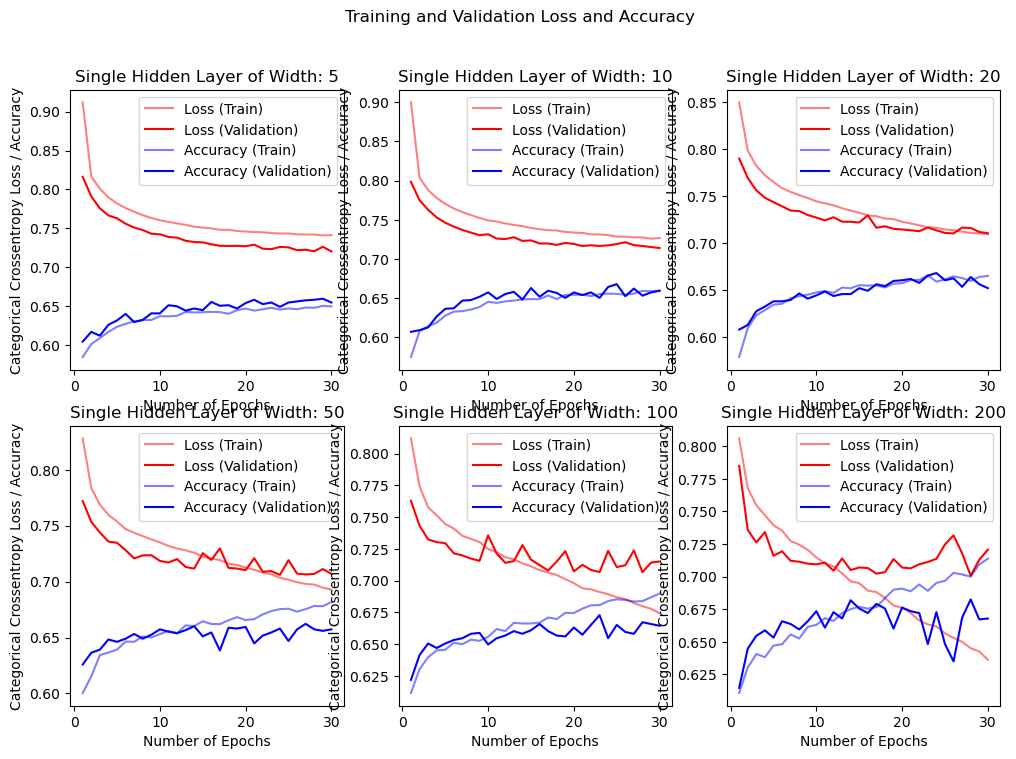

In [64]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

fig.suptitle('Training and Validation Loss and Accuracy')

for n, width in enumerate(hidden_layer_widths):
    i = n // 3
    j = n % 3
    
    plt.sca(ax[i][j])

    plt.plot(range(1,31), train_loss[n], label='Loss (Train)', color='red', alpha=0.5)
    plt.plot(range(1,31), val_loss[n], label='Loss (Validation)', color='red')
    plt.plot(range(1,31), train_acc[n], label='Accuracy (Train)', color='blue', alpha=0.5)
    plt.plot(range(1,31), val_acc[n], label='Accuracy (Validation)', color='blue')
    ax[i][j].set(title=f'Single Hidden Layer of Width: {width}',
                 xlabel='Number of Epochs',
                 ylabel='Categorical Crossentropy Loss / Accuracy')
    ax[i][j].legend();

In [65]:
model = Sequential()
# add input layer, and a dense layer with given width
model.add(layers.Input(shape=(50,)))
model.add(layers.Dense(300, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
    
model.compile(loss='categorical_crossentropy',
              metrics='accuracy')
    
results = model.fit(keras_x_train, keras_y_train,
                    validation_data = [keras_x_val, keras_y_val],
                    batch_size=30, epochs=50,
                    verbose=0)
    
history = results.history

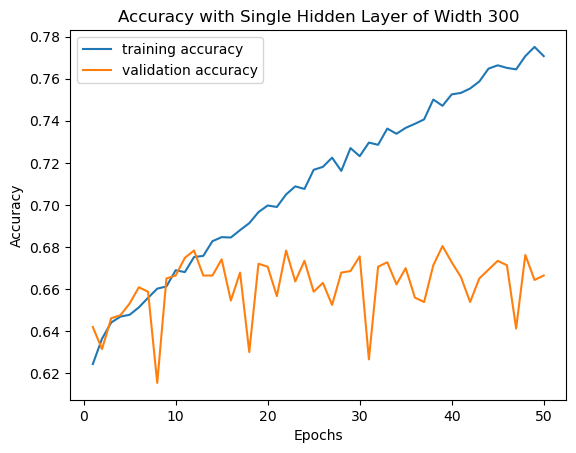

In [67]:
fig, ax = plt.subplots()

plt.plot(range(1, 51), history['accuracy'], label='training accuracy')
plt.plot(range(1, 51), history['val_accuracy'], label='validation accuracy')
ax.set(title='Accuracy with Single Hidden Layer of Width 300',
       xlabel='Epochs',
       ylabel='Accuracy')
ax.legend();

In [68]:
# add in regularization
model = Sequential()
# add input layer, and a dense layer with given width
model.add(layers.Input(shape=(50,)))
model.add(layers.Dense(300, activation='relu',
                       kernel_regularizer=keras.regularizers.L2(1e-4)))
model.add(layers.Dense(3, activation='softmax'))
    
model.compile(loss='categorical_crossentropy',
              metrics='accuracy')
    
results = model.fit(keras_x_train, keras_y_train,
                    validation_data = [keras_x_val, keras_y_val],
                    batch_size=30, epochs=50,
                    verbose=0)
    
history = results.history

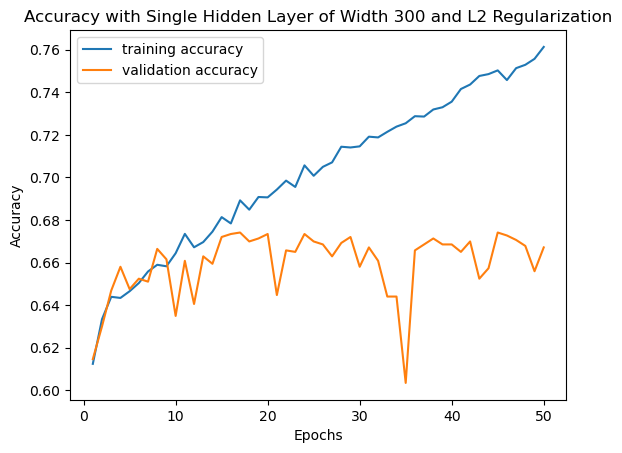

In [69]:
fig, ax = plt.subplots()

plt.plot(range(1, 51), history['accuracy'], label='training accuracy')
plt.plot(range(1, 51), history['val_accuracy'], label='validation accuracy')
ax.set(title='Accuracy with Single Hidden Layer of Width 300 and L2 Regularization',
       xlabel='Epochs',
       ylabel='Accuracy')
ax.legend();

In [70]:
# complicate the network architecture
# add in regularization
model = Sequential()
# add input layer, and a dense layer with given width
model.add(layers.Input(shape=(50,)))
model.add(layers.Dense(300, activation='relu',
                       kernel_regularizer=keras.regularizers.L2(1e-4)))
model.add(layers.Dense(50, activation='relu',
                       kernel_regularizer=keras.regularizers.L2(1e-4)))
model.add(layers.Dense(3, activation='softmax'))
    
model.compile(loss='categorical_crossentropy',
              metrics='accuracy')
    
results = model.fit(keras_x_train, keras_y_train,
                    validation_data = [keras_x_val, keras_y_val],
                    batch_size=30, epochs=50,
                    verbose=0)
    
history = results.history

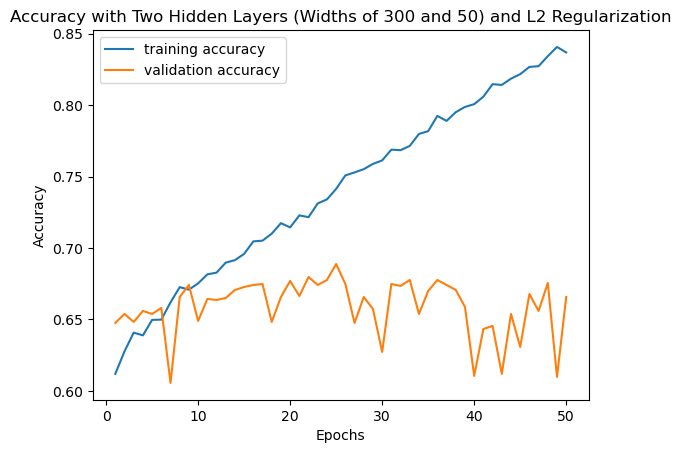

In [71]:
fig, ax = plt.subplots()

plt.plot(range(1, 51), history['accuracy'], label='training accuracy')
plt.plot(range(1, 51), history['val_accuracy'], label='validation accuracy')
ax.set(title='Accuracy with Two Hidden Layers (Widths of 300 and 50) and L2 Regularization',
       xlabel='Epochs',
       ylabel='Accuracy')
ax.legend();